In [1]:
from typing import List, Tuple, Iterable

import numpy as np
from sklearn.metrics import r2_score
import wandb
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Draw

import XAIChem

## Load data

In [2]:
train_data = XAIChem.Dataset(root="../data", name="ESOL", tag="train")
val_data = XAIChem.Dataset(root="../data", name="ESOL", tag="val")
test_data = XAIChem.Dataset(root="../data", name="ESOL", tag="test")

In [3]:
train_loader = DataLoader(train_data, batch_size=256)
val_loader = DataLoader(val_data, batch_size=256)
test_loader = DataLoader(test_data, batch_size=256)

## Model training and evaluation setup

In [4]:
def train(loader, model, criterion, optimzer):
    """
    Perform one epoch of the training step
    """
    model.train()

    # Iterate through the batches
    for i, data in enumerate(loader):
        data.to(device)
        
        out = model(data.x, data.edge_index, data.edge_type, data.batch)
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [5]:
def evaluate(loader, model, criterion):
    model.eval()

    with torch.no_grad():
        # Log average loss of batches
        losses = torch.zeros(len(loader))
    
        # Save all predictions and labels to compute the 
        # coefficient of determination (i.e. R^2) of the 
        # whole data set
        predictions = torch.zeros(len(loader.dataset))
        labels = torch.zeros(len(loader.dataset))
    
        index = 0
        for i, data in enumerate(loader):
            data.to(device)
            
            pred = model(data.x, data.edge_index, data.edge_type, data.batch)
            losses[i] = criterion(pred, data.y.view(-1, 1))
    
            new_index = index + data.batch_size
            predictions[index:new_index] = pred.view(1, -1)
            labels[index:new_index] = data.y
            index = new_index
    
        r2 = r2_score(labels, predictions)

    return r2, torch.mean(losses)

## Train models

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# wandb will be used to log the training progress
wandb.login()

for model_id in range(10):
    
    config = {
        "architecture": "RGCN by Wu et al.",
        "dataset": "ESOL from Wu et al.",
        "epochs": 500,
        "random_seed": 2022 + model_id * 10,
        "learning_rate": 0.003,
        "rgcn_dropout_rate": 0.5,
        "mlp_dropout_rate": 0.1
    }

    wandb.init(project="ESOL_reproduction", name=f"model_{model_id}_c", config=config)
    XAIChem.set_seed(config["random_seed"])

    model = XAIChem.RGCN(num_node_features=XAIChem.getNumAtomFeatures()).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    for epoch in range(config["epochs"]):
    
        train(train_loader, model, criterion, optimizer)
    
        train_r2, train_loss = evaluate(train_loader, model, criterion)
        val_r2, val_loss = evaluate(val_loader, model, criterion)
        test_r2, test_loss = evaluate(test_loader, model, criterion)
    
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_r2": train_r2,
            "val_loss": val_loss,
            "val_r2": val_r2,
            "test_loss": test_loss,
            "test_r2": test_r2,
        })
    
    torch.save(
        model.state_dict(),
        f"../data/trained_models/ESOL/ESOL_rgcn_model_{model_id}_c.pt"
    )
    wandb.finish()

wandb: Currently logged in as: xwieme (mlchem). Use `wandb login --relogin` to force relogin


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁███████████████████████████████████████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇██████████████████████████████████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▇██████████████████████████████████████
epoch,499
test_loss,0.3785
test_r2,0.91211
train_loss,0.05141


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇██████████████████████████████████████
train_loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇█▇██████████████████████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇█████████████████████████████████████
epoch,499
test_loss,0.45366
test_r2,0.89466
train_loss,0.07775


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▆▇█████████████████████████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇████████████████████████████████████
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▅▆▇████████████████████████████████████
epoch,499
test_loss,0.40663
test_r2,0.90558
train_loss,0.0553


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇██▇███████████████████████████████████
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▇▇▇███████████████████████████████████
val_loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▇▇█▇███████████████████████████████████
epoch,499
test_loss,0.38754
test_r2,0.91001
train_loss,0.0468


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▆▇█████████████████████████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇████████████████████████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇█████████████████████████████████████
epoch,499
test_loss,0.40536
test_r2,0.90587
train_loss,0.05369


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▆▇█████████████████████████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇████████████████████████████████████
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▅▆▇████████████████████████████████████
epoch,499
test_loss,0.36864
test_r2,0.9144
train_loss,0.0444


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇▇█████████████████████████████████████
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇█████████████████████████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇█████████████████████████████████████
epoch,499
test_loss,0.4328
test_r2,0.8995
train_loss,0.04727


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇▇▇▇███████████████████████████████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇▇▇██████████████████████████████████
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇▇▇▇██████████████████████████████████
epoch,499
test_loss,0.40823
test_r2,0.90521
train_loss,0.04438


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇▇█████████████████████████████████████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▇▇█▇██████████████████████████████████
val_loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▇▇▇█▇██████████████████████████████████
epoch,499
test_loss,0.42568
test_r2,0.90115
train_loss,0.07132


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇██████████████████████████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇████████████████████████████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇▇████████████████████████████████████
epoch,499
test_loss,0.39585
test_r2,0.90808
train_loss,0.06903


## Substructure mask explanation

In [2]:
models = []

for model_id in range(10):
    model = XAIChem.RGCN(num_node_features=XAIChem.getNumAtomFeatures())
    model.load_state_dict(
        torch.load(
            f"../data/trained_models/ESOL/ESOL_rgcn_model_{model_id}_b.pt",
            map_location=torch.device('cpu')
        )
    )
    model.eval()
    models.append(model)

In [3]:
def predict(graph, mask=None):

    predictions = torch.zeros(10)
    for i, model in enumerate(models):
        predictions[i] = model(
            graph.x, 
            graph.edge_index, 
            graph.edge_type, 
            torch.zeros(1, dtype=torch.long),
            mask
        )

    return torch.mean(predictions), torch.std(predictions)

### Menthol

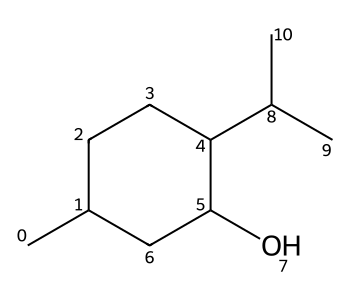

In [4]:
menthol_smiles = "CC1CCC(C(C1)O)C(C)C"
menthol_rdmol = Chem.MolFromSmiles(menthol_smiles)
menthol_rdmol
XAIChem.showMolecule(menthol_rdmol, show_atom_indices=True)

In [5]:
functional_groups = ["[OH]", "[CH3]", "[SH]", "[CH3]-[CH][CH3]"]

In [6]:
for functional_group in functional_groups:
    print(menthol_rdmol.GetSubstructMatches(Chem.MolFromSmarts(functional_group)))

((7,),)
((0,), (9,), (10,))
()
((9, 8, 10),)


In [7]:
frags = list(BRICS.BRICSDecompose(menthol_rdmol))
mols = [Chem.MolFromSmiles(frag) for frag in frags]

In [13]:
bricks_substructures = [
    XAIChem.breakBRICKSBond(menthol_rdmol, bond[0])
    for bond in BRICS.FindBRICSBonds(menthol_rdmol)
]

In [16]:
for bricks_substructure in bricks_substructures:
    for substructure in bricks_substructure:
        mask = torch.zeros(menthol_rdmol.GetNumAtoms(), dtype=int)
        
        for i, atom in enumerate(menthol_rdmol.GetAtoms()):
            mask[i] = atom.GetIdx() not in substructure
        
        print(mask)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])


In [196]:
graph = XAIChem.createDataObjectFromSmiles(menthol_smiles, -1)

with torch.no_grad():
    # Prediction of molecule without mask
    pred_mean, pred_sd = predict(graph)
    print(pred_mean, pred_sd)

    # Mask hydroxyl group
    pred_mean_masked_hydroxyl, pred_sd_masked_hydroxyl = predict(
        graph, mask.view(-1, 1)
    )
    print(pred_mean_masked_hydroxyl, pred_sd_masked_hydroxyl)

tensor(-3.8441) tensor(0.1910)
tensor(-4.2353) tensor(0.1500)


In [88]:
attribution = pred_mean - pred_mean_masked_hydroxyl
attribution_N = F.tanh(attribution)

In [89]:
attribution

tensor(0.9074)

In [90]:
attribution_N

tensor(0.7199)

### p-Menthane

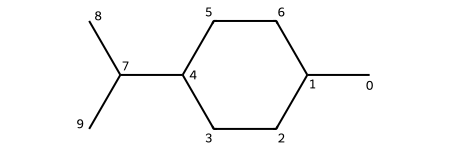

In [105]:
p_menthane_smiles = "CC1CCC(CC1)C(C)C"
p_menthane_rdmol = Chem.MolFromSmiles(p_menthane_smiles)
p_menthane_rdmol

In [47]:
graph = XAIChem.createDataObjectFromSmiles(p_menthane_smiles, -1)

with torch.no_grad():
    # Prediction of molecule without mask
    pred_mean, pred_sd = predict(graph)
    print(pred_mean, pred_sd)

tensor(-4.9916) tensor(0.1944)


In [48]:
np.exp(pred_mean)

tensor(0.0068)

In [133]:
substructure = (9, 7, 8)
substructure_bonds = set()

for atom_id in substructure:
    bonds = p_menthane_rdmol.GetAtomWithIdx(atom_id).GetBonds()

    for bond in bonds:
        begin_atom_id = bond.GetBeginAtomIdx()
        end_atom_id = bond.GetEndAtomIdx()

        if (begin_atom_id != atom_id and begin_atom_id in substructure) or\
            (end_atom_id != atom_id and end_atom_id in substructure):
            substructure_bonds.add(bond.GetIdx())

print(substructure_bonds)

{8, 7}


In [115]:
p_menthane_rdmol.GetAtoms()[0].GetBonds()[0]

In [108]:
for atom in p_menthane_rdmol.GetAtoms():
    print(atom.GetBonds())

(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1230>,)
(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1540>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e0d60>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1620>)
(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1230>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e0d60>)
(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1540>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e0d60>)
(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1230>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e0d60>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1620>)
(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1540>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e0d60>)
(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1230>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e0d60>)
(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1540>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e0d60>, <rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1620>)
(<rdkit.Chem.rdchem.Bond object at 0x7f39fd8e1230>,)
(<rdkit.Chem.rdchem.